# ResNet 50 Model
Note: notebook can run all code needed for the model including predictions. Adjust files according to input path on your device. All files here are the same as the ones on the Kaggle database.
## Preprocessing Data

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
import plotly.express as px
import plotly.figure_factory as ff

from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

In [8]:
# Load Kaggle dataset
dataset = pd.read_csv('training.csv')

# In our dataset there are many missing values
# Take care of these missing values with the median
dataset.fillna(dataset.describe().T['50%'], inplace=True)
dataset.sample(5).T

,943,4804,5154,2141,387
left_eye_center_x,65.667404,69.933672,64.546423,64.680424,66.592640
left_eye_center_y,37.777702,34.890538,45.342021,42.272124,35.958336
right_eye_center_x,31.892426,31.249379,34.355438,34.153278,32.556160
right_eye_center_y,36.560613,38.076303,35.853408,31.515221,35.386304
left_eye_inner_corner_x,59.581957,59.304615,59.304615,57.026474,60.300160
left_eye_inner_corner_y,38.386247,37.878040,37.878040,41.607206,37.102464
left_eye_outer_corner_x,71.144851,73.247824,73.247824,73.247824,71.741440
left_eye_outer_corner_y,37.473430,37.639015,37.639015,37.639015,37.102464
right_eye_inner_corner_x,37.369872,36.651562,36.651562,39.989785,37.418880
right_eye_inner_corner_y,37.169157,37.944075,37.944075,35.164884,37.102464


In [9]:
# Create functions to load and show images
# sort_pattern: sorts for all the images 0.jpg to 7048.jpg
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# load_images: load all the images from the path into an array
def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_file = sorted(file_list, key=sort_pattern)

    for filename in sorted_file:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img))
            img.close()

    return images

# show_keypoints: print out a grid of plots with images that have the keypoints displayed
def show_keypoints(images, keypoints, n_rows=3, n_cols=7):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        img_array = np.array(images[i], dtype=np.uint8)
        img_array = img_array.squeeze()
        img = Image.fromarray(img_array)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Sample #{i}')

        for j in range(0, len(keypoints[i]), 2):
            x = keypoints[i][j]
            y = keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

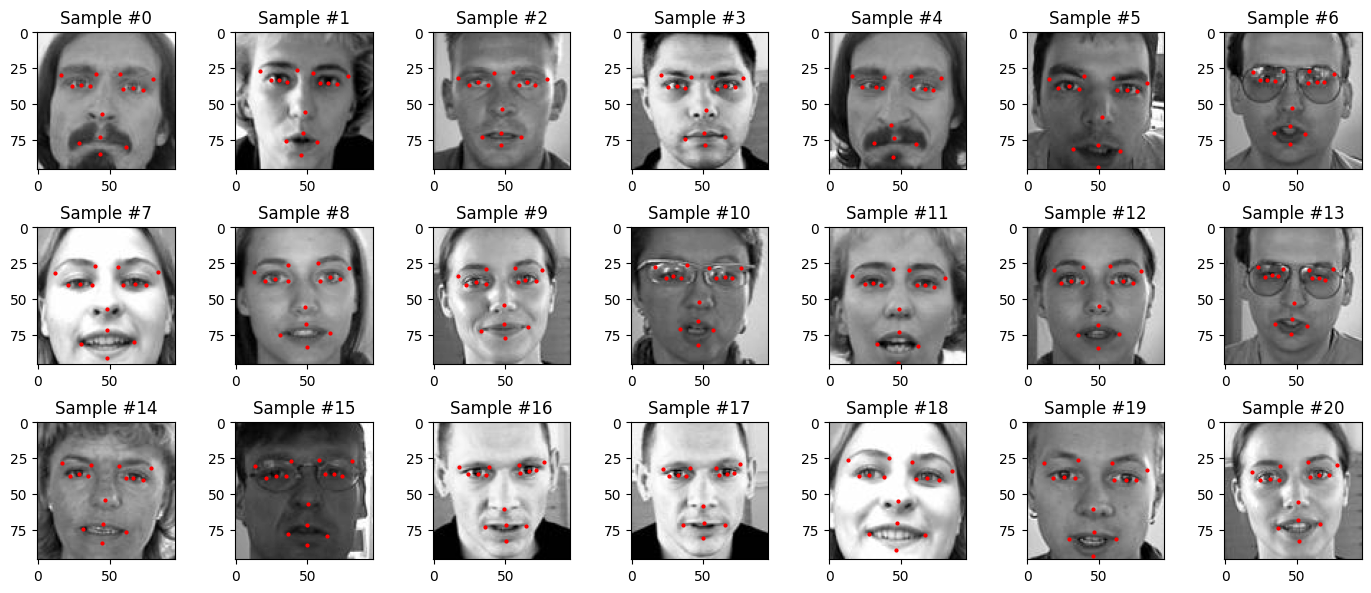

In [10]:
# Load the images from the path
# Depends on where you put the 7049 images in your device
path = r"train_images"
images = load_images(path)

# Split the training and testing data
images = np.array(images).reshape(-1, 96, 96, 1).astype('float64')
data = dataset.values.astype('float64')
x_train, x_test, y_train, y_test = train_test_split(images, data, test_size=0.2, shuffle=False, random_state=42)

# Show some examples
show_keypoints(x_train[:21], y_train[:21])

## Building the Model
With ResNet (residual network) we don't have to worry about the vanishing gradient. So we set up the model by putting in our own numbers of input shape and other variables such as our activation function. Then build upon the pretrained network to apply transfer learning.

In [11]:
# Start up the model and put in the convolutional 2D layer with our shape
# In our case, we are doing a 96, 96 image using ReLu function
resnet_model = tf.keras.models.Sequential()
resnet_model.add(Conv2D(3, (1, 1), padding='same', input_shape=(96, 96, 1)))
resnet_model.add(LeakyReLU(alpha=0.1))

# Add the pretrained portion of the model from the ImageNet weights
pretrained_model = ResNet50(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
pretrained_model.trainable = True
resnet_model.add(pretrained_model)

# Put in the pooling layer for spatial dimensions and control the dropout for overfitting
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dropout(0.1))

# Add a Dense layer with 30 output nodes for facial keypoints
resnet_model.add(Dense(30))
resnet_model.summary()

# Early stopping to prevent overfitting by monitoring loss
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min', baseline=None)

# Reduce learning rate to improve convergence
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)
resnet_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 30)                61

## Train the Model
We put the models to train for 100 epochs and included the early stopping and reducing of learning rate to control the training.

In [12]:
history = resnet_model.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping, reduce_LR], batch_size=32)

Epoch 1/100
141/141 [==============================] - 60s 113ms/step - loss: 167.1586 - mae: 5.7924 - acc: 0.4624 - val_loss: 29.2800 - val_mae: 4.0472 - val_acc: 0.2358 - lr: 0.0010
Epoch 2/100
141/141 [==============================] - 13s 90ms/step - loss: 8.0646 - mae: 1.8467 - acc: 0.6280 - val_loss: 151.9167 - val_mae: 11.1174 - val_acc: 0.7704 - lr: 0.0010
Epoch 3/100
141/141 [==============================] - 14s 97ms/step - loss: 6.1385 - mae: 1.6554 - acc: 0.7196 - val_loss: 148.1042 - val_mae: 10.9805 - val_acc: 0.7917 - lr: 0.0010
Epoch 4/100
141/141 [==============================] - 13s 93ms/step - loss: 5.1570 - mae: 1.5299 - acc: 0.7553 - val_loss: 35.4254 - val_mae: 5.3891 - val_acc: 0.8209 - lr: 0.0010
Epoch 5/100
141/141 [==============================] - 13s 95ms/step - loss: 4.4200 - mae: 1.4304 - acc: 0.7774 - val_loss: 60.5331 - val_mae: 7.1384 - val_acc: 0.8094 - lr: 0.0010
Epoch 6/100
141/141 [==============================] - 13s 92ms/step - loss: 4.0042 - ma

In [13]:
resnet_model.save("ResNet50Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Results
Here are the graphs and results of the training

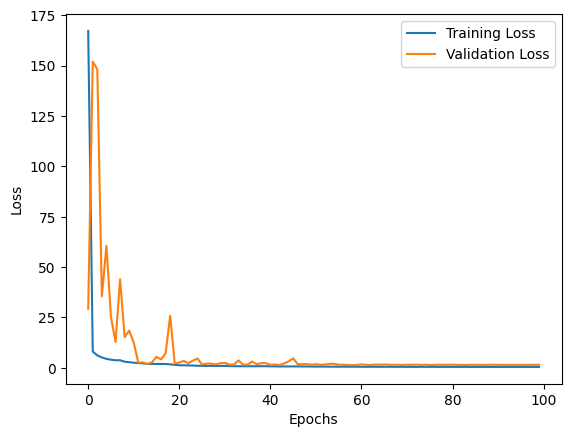

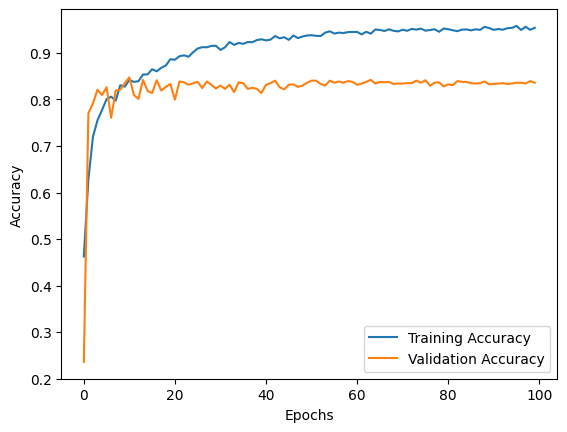

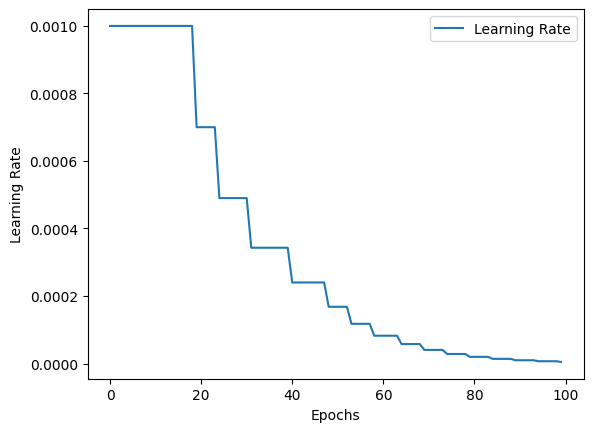

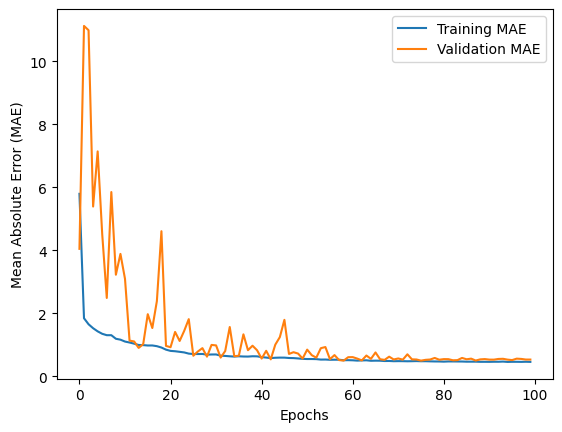

In [14]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot learning rate
plt.plot(history.history['lr'], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

# Plot mean squared error
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

## Predictions
Predict on the test images to see if the model does well. Also, calculate the mean squared error between the prediction and the actual values they are made of.

45/45 [==============================] - 2s 31ms/step


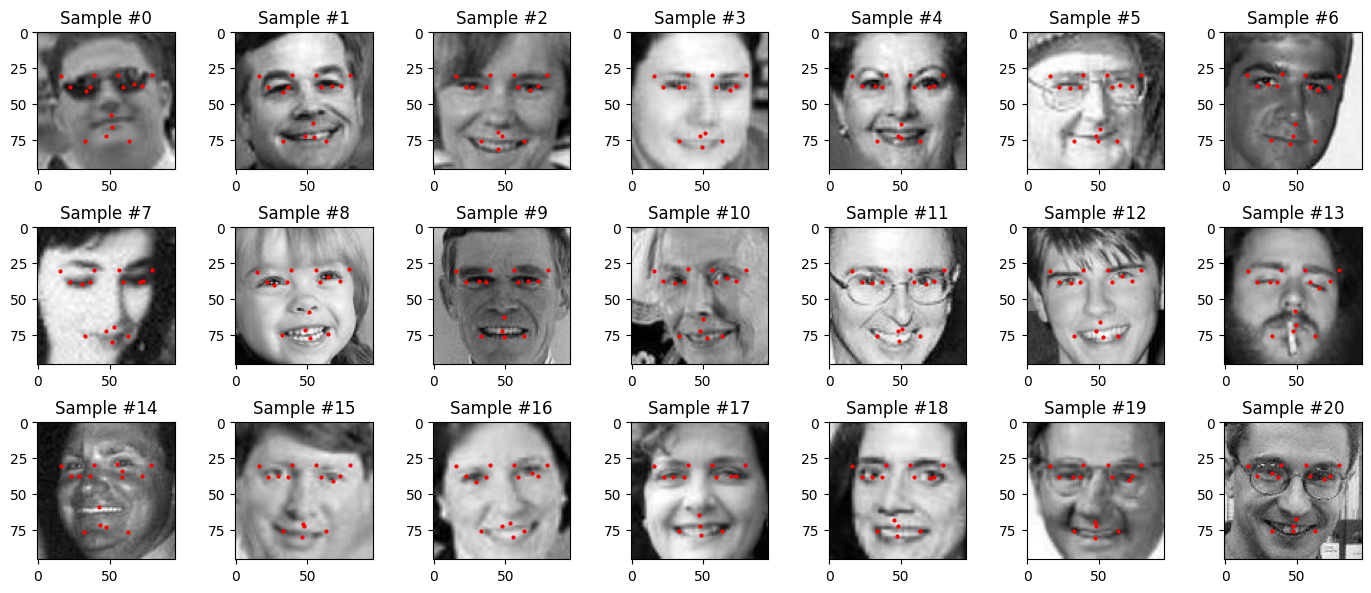

In [15]:
y_pred = resnet_model.predict(x_test)

# Predicted points on the images
show_keypoints(x_test[:21], y_pred[:21])

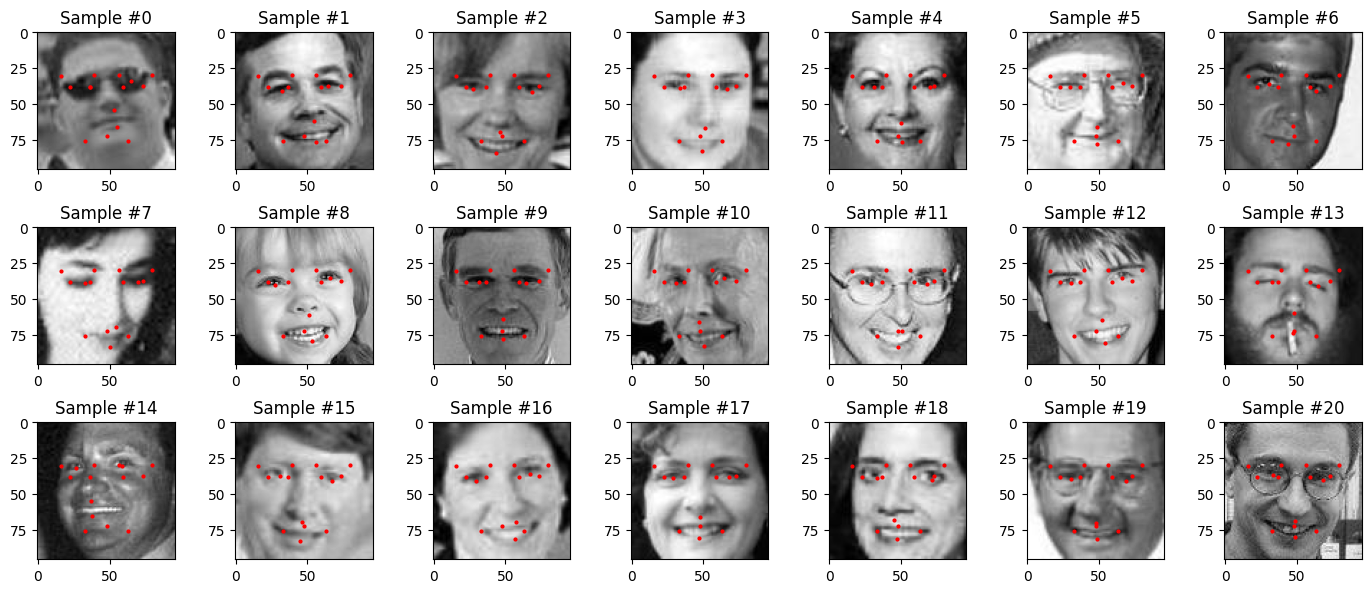

Mean Squared Error: 1.826411314538575


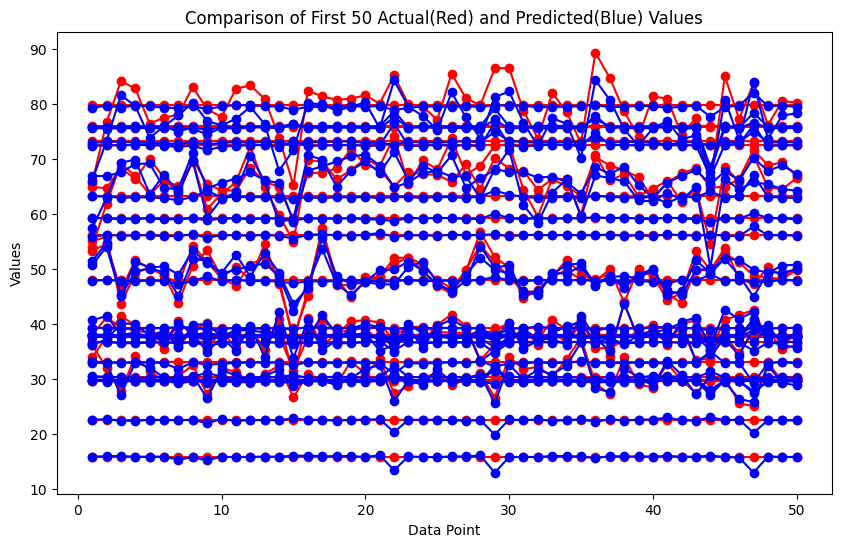

In [16]:
# Actual points on the same set of images
show_keypoints(x_test[:21], y_test[:21])

y_actual = np.array(y_test)
y_prediction = np.array(y_pred)
differences = y_actual - y_prediction
squared_differences = differences ** 2
mse = np.mean(squared_differences)
print("Mean Squared Error:", mse)

plt.figure(figsize=(10, 6))

plt.plot(range(1, 51), y_actual[:50], 'ro-', label='Actual')
plt.plot(range(1, 51), y_prediction[:50], 'bo-', label='Predicted')

# Customize the plot
plt.title('Comparison of First 50 Actual(Red) and Predicted(Blue) Values')
plt.xlabel('Data Point')
plt.ylabel('Values')
plt.show()